Importiamo le librerie

In [21]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

In [37]:
# Definiamo la funzione f(x, alpha) che prende in input il vettore alpha dei coefficienti e un valore x, e ritorna il valore del rispettivo polinomio
# Questa funzione si chiama funzione di ipotesi
def f(x, alpha):
    d = alpha.shape[0] - 1 # Abbiamo detto che la shape di alpha è (d+1, )
    y = np.zeros_like(x)
    for i in range(d+1):
        y = y + alpha[i] * x ** i
    return y

def vandermonde(x, k):
    n = x.shape[0]
    X = np.zeros((n, k+1)) # d+1 perchè le colonne vanno da x^0 a x^k
    for i in range(k+1):
        X[:, i] = x ** i # Prendi tutti gli elementi della prima colonna x^0
    return X

d = 5 # Grado del polinomio
n = 15 # Numero di dati

# Definiamo alpha_true = (1, 1, ..., 1) 
alpha_true = np.ones((d+1,))

# Scegliamo un valore di x
x = np.linspace(0, 1, n)

X = vandermonde(x, d) # Questa matrice ha il rango massimo!!!

# Generiamo il rumore
e = np.random.normal(loc=0, scale=0.2, size=(n, ))

# Inizializziamo y (zeros_like(x) genera una matrice come x, ma con 0)
y = np.zeros_like(x)

# Calcoliamo tutte le y
for i in range(n):
    y[i] = f(x[i], alpha_true) + e[i]

print(y) # questi sono i dati reali

[0.75757943 0.97074949 1.19725275 1.53845608 1.66511318 1.66883668
 1.54230737 2.42909771 2.27723307 2.7337479  3.14879427 3.49645905
 4.52156351 4.78504387 5.94110815]


Ora, dato un vettore $\alpha$ di lunghezza $d+1$, possiamo calcolare il valore del **residuo**, definito come:

$$
r(\alpha) := || X\alpha - y ||_2^2,
$$

che misura la discrepanza tra la previsione del modello di approssimazione (cioè $X\alpha$), e i dati misurati ($y$). Risolvere il problema ai minimi quadrati corrisponde a minimizzare questa quantità. 

In [32]:
def residuo(X, y, alpha):
    r = np.linalg.norm(X @ alpha - y) ** 2
    return r

# Testiamo la funzione con un alpha generato casualmente
alpha = np.random.randn(d+1)
print(f"Residuo: {residuo(X, y, alpha)}.")

Residuo: 65.67816069498905.


## Risoluzione mediante Equazioni Normali
Dobbiamo quindi trovare il valore di $\alpha$ che risolva:

$$
\min_{\alpha} || X\alpha - y ||_2^2.
$$

Avete già visto a lezione che questo può essere fatto risolvendo le **equazioni normali** associate a tale problema, ovvero:

$$
X^T X \alpha = X^T y.
$$

Questo può essere fatto tramite:

* Decomposizione di Cholesky; (CHE NON ABBIAMO FATTO!)
* Decomposizione ai Valori Singolari (SVD);

Vediamo i due metodi nel dettaglio.

### Risoluzione tramite fattorizzazione LU

Siccome $X$ ha dimensione $(n, d+1)$, e siccome (auspicabilmente), $n \gg d+1$, allora il rango di $X$ è massimo se e solo se è uguale a $d+1$. Verifichiamo che questo succede.

Possiamo quindi applicare la fattorizzazione LU, 

$$
X^T X = L U.
$$

Il sistema dell equazioni normali può quindi essere risolto tramite il metodo della sostituzione all'Avanti e all'Indietro, ovvero risolvendo i due sistemi (triangolari):

$$
\begin{cases}
    L z = X^T y \\
    U \alpha = z.
\end{cases}
$$

In Python:

In [33]:
#Calcoliamo la matrice dei coefficienti delle equazioni normali
XtX=X.T@X

# Calcoliamo il termine noto X^T y
Xty = X.T @ y

# Troviamo z
alpha_eqn= np.linalg.solve(XtX, Xty)

Una volta trovata la nostra soluzione `alpha_sol`, visualizziamo su grafico come viene la curva calcolata tramite questo algoritmo di approssimazione rispetto ai dati che abbiamo a disposizione e rispetto alla curva vera. 

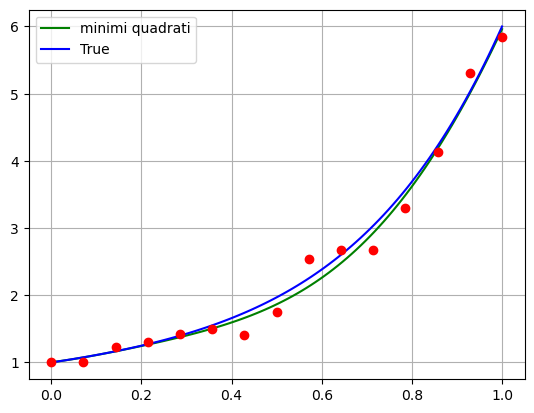

In [35]:
# Rappresentiamo la curva *approssimata* in [0, 1]
xx = np.linspace(0, 1, 100)

plt.plot(xx, f(xx, alpha_eqn), 'g')
plt.plot(xx, f(xx, alpha_true), 'b')
plt.plot(x, y, 'ro')
plt.legend(["minimi quadrati", "True"])
plt.grid()
plt.show()
# Il primo grafico si ha (xx, yy_TRUE) è la funzione ESATTA,
# Il secondo grafico ha (xx,yy_eqn) è la funzione REALE

E' abbastanza chiaro che la curva ricostruita non riesce ad approssimare correttamente i dati. Prima di discutere le ragioni e le possibili soluzioni di questo comportamento, vediamo come risolvere in maniera alternativa il problema ai minimi quadrati tramite decomposizione a valori singolari.

### Risoluzione tramite SVD
Consideriamo la decomposizione a Valori Singolari (SVD) della matrice $X$:

$$
X = U \Sigma V^T,
$$

dove $U \in \mathbb{R}^{n \times n}$ e $V \in \mathbb{R}^{(d+1) \times (d+1)}$ sono matrici ortogonali, mentre $\Sigma \in \mathbb{R}^{n \times (d+1)}$ è una matrice diagonale i cui elementi sulla diagonale sono i valori singolari di $X$, in ordine decrescente.

In Python, è possibile calcolare la decomposizione SVD di $X$ tramite il comando `np.linalg.svd(X)`. Questa funzione ritorna tre `ndarray`: `U`, `s` e `VT`, dove `U` e `VT` rappresentano le matrici $U$ e $V^T$, rispettivamente, mentre `s` è un vettore che rappresenta la diagonale di $\Sigma$, ovvero i valori singolari della matrice $X$, in ordine decrescente.

In [26]:
# Calcoliamo la SVD di X
U, s, VT = np.linalg.svd(X)

# Costruiamo la matrice Sigma esplicitamente (per controllare che la SVD sia stata 
# svolta correttamente)
Sigma = np.zeros((n, d+1))
for i in range(d+1):
    Sigma[i, i] = s[i]

# Calcoliamo || X - U * Sigma * VT ||
print(f"|| X - U Sigma V^T || = {np.linalg.norm(X - U @ Sigma @ VT)}")

|| X - U Sigma V^T || = 5.462135610975701e-15


Ricordando che le matrici $U$ e $V$ sono ortognali, le equazioni normali diventano:

$$
X^T X \alpha = X^T y \iff V \Sigma^2 V^T \alpha = V \Sigma U^T y \iff \Sigma^2 V^T \alpha = \Sigma U^T y
$$

La cui soluzione esplicita è:

$$
    \alpha = \sum_{i=1}^{d+1} \frac{u_i^T y}{\sigma_i} v_i. 
$$


Questa operazione può semplicemente essere implementata in Python come:

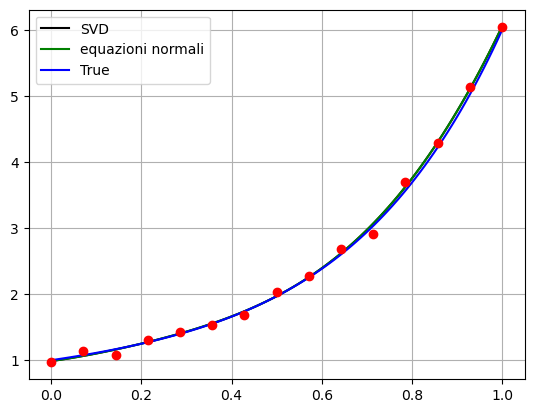

In [27]:
# Inizializzazione di alpha
alpha_svd = np.zeros((d+1, ))

# Aggiornamento
for i in range(d+1):
    uTb = U[:, i].T @ y
    alpha_svd = alpha_svd + uTb / s[i] * VT[i, :]

# Rappresentiamo tutte le soluzioni su grafico
xx = np.linspace(0, 1, 100)
yy_true = f(xx, alpha_true)
yy_chol = f(xx, alpha_eqn)
yy_svd = f(xx, alpha_svd)

plt.plot(xx, yy_svd, 'k')
plt.plot(xx, yy_eqn, 'g')
plt.plot(xx, yy_true, 'b')
plt.plot(x, y, 'ro')
plt.legend(["SVD", "equazioni normali", "True"])
plt.grid()
plt.show()
# Ora abbiamo yy_svd !!!!!!!!!
# DA NOTARE CHE SE ABBIAMO IL RANGO MASSIMO (come in questo caso) EQUAZIONI NORMALI E SVD HANNO LO STESSO RISULTATO!!!

Le soluzioni $\alpha_{chol}$ e $\alpha_{SVD}$ sono, come ci si aspetta, identiche, poiché soluzioni dello stesso problema dei minimi quadrati, che ha soluzione unica.

> **Esercizio:** Prova a ri-eseguire lo script precedente modificando:
> - il numero $n$ dei dati,
> - il grado del polinomio che genera il problema test,
> - la quantità di rumore aggiunto sui dati,
> - il grado del polinomio del modello approssimante.
> 
> Cosa osservi, riguardo al comportamento del polinomio approssimante risultante?

Se all'inizio prendiamo $d=3$ anzichè $d=5$, avremo due curve molto più simili tra di loro